# Assignment 04 - Garbage Bin Classification problem 


This assignment is the continuation of assignment 01, where the teams were tasked with designing a garbage classification system.

For the first assignmnet 4,068 images were collected. With the following distribution:

- **Blue bin** (recyclable): 2,398 images
- **Green bin** (compostable):      826 images
- **Black bin** (landfill):         844 images 


For this assignment, your team needs to develop/implement/code the garbage classification model. You are free to use any technique seen in class that you want (*e.g.*, CNNs, transfer learning, etc.). You will have access only to the development set. The TAs will run your code on the test set to extract the accuracy and confusion matrix metrics.

The development set can be downloaded here:

- [OneDrive](https://uofc-my.sharepoint.com/:u:/g/personal/roberto_medeirosdeso_ucalgary_ca/EYEMTmqSm9RGodAIQDKB5lwBp2xyWtNm8qQ0wj7JV2XiPA?e=1xhhDh) - Link expires March 10th, 2021.
- [GDrive](https://drive.google.com/file/d/1-q56xKd4yEsFo5xwz5Rd1Zn_lyCXLaMU/view?usp=sharing)

The data has already been pre-processed for you. Images were resized to 512 x 400 pixels and converted to PNG. Be mindful that a considerable number of samples in the development set may have been incorrectly labelled. Your team is free to fix some of the labels if you think this will help to develop your model. [See what goes where](https://www.calgary.ca/uep/wrs/what-goes-where/default.html) to get information about the labels.


The Jupyter Notebook should be divided into two parts: 1. Model development; 2. Model testing. The model development will be run by you, while the model testing will be run by the TAs when grading the assignment.


The deliverables for this assignment are:

1. This jupyter-notebook completed with your solution. 
    - Name the notebook as enel645_assignment04_team_(team number).ipynb
2. The weights of your best model after training. 
    - Name the weights' file as team_(team number)_garbage.h5 


Submit the two files (notebook + models' weights) to your dropbox on the course D2L page.
    
You are free to add extra cells of text and code to this notebook. You are free to use the TALC cluster to train your model, but remember that your code should be submitted as a Jupyter Notebook and not ".py" file.

Please include a short description of what each team member did in the assignment at the end of the notebook. Also include the consensus score between 0 and 3 for each team member. This score will be used to adjust the final grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


## 1. Model development;

In [1]:
# Get GPU Working with CuDNN
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Develop your model here feel free to add additional cells
# Comment and justify your choices as much as you can.

In [2]:
import numpy as np
import pandas as pd
import random
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
import python_utils as utils
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline

In [3]:
# Set Config Variables
batch = 128 
num_classes = 3
model_name_vgg = "team_18_garbage_vgg"
model_name_resnet = "team_18_garbage_resnet"
Img_dims = (512, 400, 3)

black_path = './Garbage-classification-dataset/Development/Black'
green_path = './Garbage-classification-dataset/Development/Green'
blue_path = './Garbage-classification-dataset/Development/Blue'

### Loading Dataset

In [4]:
# Load Dataset - Sonia: Download the dataset (look at assignment instructions)


path = './Garbage-classification-dataset/Development/'
black_files = [f for f in glob.glob(path + "*/*.png", recursive=True)]
print(black_files[0])

./Garbage-classification-dataset/Development\Black\black_0.png


In [5]:
label_map = {'black':0,
             'blue':1,
             'green':2,}
label = [label_map[os.path.basename(file).split('_')[0]] for file in black_files]
print(label[0])

0


# Visualize Dataset - Sonia: Visualize the dataset similar to A2
plt.figure(figsize=(20,20))

for i in range(5):
    file = random.choice(os.listdir(path))
    image_path= os.path.join(path, file)
    with open(image_path, "r") as f:
        img=mpimg.imread(f)
        ax=plt.subplot(1,5,i+1)
        ax.title.set_text(file)
        plt.imshow(img)

In [20]:
# Creating datasets
def create_dataset(img_folder, name):
    img_data_array=[]
    class_name=[]
    
    for file in os.listdir(img_folder):
       
        image_path= os.path.join(img_folder, file)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (400, 512),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255  # Normalizing image
        img_data_array.append(image)
        class_name.append(name)
        
    return img_data_array, class_name

In [21]:
img_data_black, labels_black = create_dataset(black_path, "black")
img_data_blue, labels_blue = create_dataset(blue_path, "blue")
img_data_green, labels_green = create_dataset(green_path, "green")

In [22]:
print("image: ", img_data_black[0].shape, "label: ", labels_black[0])
print("image: ", img_data_blue[0].shape, "label: ", labels_blue[0])

image:  (512, 400, 3) label:  black
image:  (512, 400, 3) label:  blue


In [23]:
def shuffle_index(data, lbl=None):
    data = np.array(data)
    indexes = np.arange(len(data), dtype = int)
    np.random.shuffle(indexes)
    data = data[indexes]
    if lbl is not None:
        lbl = lbl[indexes]
        return data, lbl
    return data

def split_dataset(data, lbls):
    train, val, test = np.split(data, [int(.7 * len(data)), int(.8 * len(data))])
    labels_tr, labels_val, labels_test = np.split(lbls, [int(.7 * len(lbls)), int(.8 * len(lbls))])
    return train, val, test, labels_tr, labels_val, labels_test

In [24]:
# Split into Train, Validation and Test sets - Tabish/Regina

# Let's shuffle the samples
img_data_black = shuffle_index(img_data_black)
img_data_blue = shuffle_index(img_data_blue)
img_data_green = shuffle_index(img_data_green)

print("Black Len: ", len(img_data_black), " Blue Len: ", len(img_data_blue), " Green Len: ", len(img_data_green))

# Creating train, validate and test datasets of each class
train_black, test_black, val_black, labels_tr_black, labels_test_black, labels_val_black= split_dataset(img_data_black, 
                                                                                                        labels_black)
train_blue, test_blue, val_blue, labels_tr_blue, labels_test_blue, labels_val_blue = split_dataset(img_data_blue, labels_blue)
train_green, test_green, val_green, labels_tr_green, labels_test_green, labels_val_green = split_dataset(img_data_green, 
                                                                                                         labels_green)

print("Black train Len: ", len(train_black), " ", len(labels_tr_black), " Black val Len: ", len(val_black), " ", 
      len(labels_val_black), " Black test Len: ", len(test_black), " ", len(labels_test_black))

print("Black train type: ", type(train_black), " ", type(labels_tr_black), " Black val type: ", type(val_black), " ", 
      type(labels_val_black), " Black test type: ", type(test_black), " ", type(labels_test_black))
print("train shape: ", train[0].shape)


Black Len:  744  Blue Len:  2298  Green Len:  726
Black train Len:  520   520  Black val Len:  149   149  Black test Len:  75   75
Black train type:  <class 'numpy.ndarray'>   <class 'numpy.ndarray'>  Black val type:  <class 'numpy.ndarray'>   <class 'numpy.ndarray'>  Black test type:  <class 'numpy.ndarray'>   <class 'numpy.ndarray'>
train shape:  (400, 512, 3)


In [25]:
# Combine different classes to form train, validate and test datasets
train =  np.vstack((train_black, train_blue, train_green))
val = np.vstack((val_black, val_blue, val_green))
test = np.vstack((test_black, test_blue, test_green))

train_lbls = np.concatenate((labels_tr_black, labels_tr_blue, labels_tr_green))
val_lbls = np.concatenate((labels_val_black, labels_val_blue, labels_val_green))
test_lbls = np.concatenate((labels_test_black, labels_test_blue, labels_test_green))

print("train Len: ", len(train), " ", len(train_lbls), " val Len: ", len(val), " ", 
      len(val_lbls), "test Len: ", len(test), " ", len(test_lbls))
print("train shape: ", train[0].shape)
print("train shape: ", val[0].shape)

train Len:  2636   2636  val Len:  755   755 test Len:  377   377
train shape:  (512, 400, 3)
train shape:  (512, 400, 3)


In [26]:
# Shuffle train, validate and test datasets and thier labels
train, train_lbls = shuffle_index(train, train_lbls)
val, val_lbls = shuffle_index(val, val_lbls)
test, test_lbls = shuffle_index(test, test_lbls)

print("train shape: ", train[0].shape)

train shape:  (512, 400, 3)


In [19]:
# One-Hot Encode Labels - Tabish/Regina
train_lbls =  [label_map[train_lbls[i]] for i in range(len(train_lbls))]
val_lbls =  [label_map[val_lbls[i]] for i in range(len(val_lbls))]
test_lbls =  [label_map[test_lbls[i]] for i in range(len(test_lbls))]

Y_train_oh = tf.keras.utils.to_categorical(train_lbls)
Y_val_oh = tf.keras.utils.to_categorical(val_lbls)
Y_test_oh = tf.keras.utils.to_categorical(test_lbls)

print("Labels:")
print(train_lbls[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

KeyError: 1

## Model Creation

In [ ]:
# Define Callback Functions  - Regina

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

monitor_func = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',
                                                  verbose=0, save_best_only=True,
                                                  save_weights_only=True, mode='min')


# Learning rate schedule
def scheduler(epoch, lr):
    if epoch % 10 == 0:
        lr = lr / 2
    return lr


lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [ ]:
# Load Pre-trained Model - Regina
new_input = Input(shape=(512, 400, 3))

# ----------------- VGG16 Model ----------------- #
# Load Model with new Input layer and Output Layers
model_VGG16 = VGG16(include_top=False, input_tensor=new_input, pooling='avg')
flat1 = tf.keras.layers.Flatten()(model.layers[-1].output)
class1 = tf.keras.layers.Dense(1024, activation='relu')(flat1)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(class1)
model_VGG16 = tf.keras.models.Model(inputs=model_with_weights.inputs, outputs=output)

# Setting some layers as not trainable
model_VGG16.get_layer('block1_conv1').trainable = False
model_VGG16.get_layer('block1_conv2').trainable = False
model_VGG16.get_layer('block2_conv1').trainable = False
model_VGG16.get_layer('block2_conv2').trainable = False

# ----------------- ResNet50  ----------------- #
# Load Model with new Input layer
model_ResNet50 = ResNet50(include_top=False, input_tensor=new_input, pooling='avg')
# 

In [ ]:
# Train VGG16 Model - Lai

## ResNet50 Transfer Learning Training

In [ ]:
#this cell for definitions to test model without others sections
#comment out when completed or delete
img_height = 512
img_width = 400

In [ ]:
# Train ResNet50 Model - Nate
base_ResNet50 = tf.keras.applications.ResNet50( # Base model must have unique name as multiple models are in play
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) # removes prediction layer so we can add our own

base_ResNet50.trainable = False # freezes model weights so we can train a new prediction layer

In [ ]:
input_image = tf.keras.Input(shape=(img_height, img_width, 3)) # define input for model
x1 = base_ResNet50(input_image, training=False) # this layer is the ResNet50 model we brought in without predicting layer
x2 = tf.keras.layers.Flatten()(x1) #flattens ResNet50 output for dense prediction layer
out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(x2)
model_ResNet50 = tf.keras.Model(inputs = input_image, outputs =out) # Model must have unique name as multiple models are in play (VGG16)
print(model_ResNet50.summary())

TODO

Get training data name and replace "training_data" with it below as well as validation data

In [ ]:
model_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# TRAINING DATA NEEDS TO GO BELOW
model_ResNet50.fit(training_data,epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_data)) # Validatation data must replace "val_data"

### Model Fine Tuning

In [ ]:
base_ResNet50.trainable = True
model_ResNet50.load_weights(model_name) #should be defined in callbacks "garbage_classification_group_18_ResNet50.h5"
model_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-9), # Very low learning rate to fine tune
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model_ResNet50.summary())
model.fit(train_flow, epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_data)) # replace with proper validation data

## 2. Model Testing

In [ ]:
# You are free to adapt this portion of the code, but you should 
# compute the test accuracy and show the images that 
# were classified incorrectly
test_data_dir = "/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/Garbage-classification/Dataset-curated/Resized/Test/"

model.load_weights(model_name)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0) 
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,shuffle = False)
nb_samples = len(glob.glob(test_data_dir + "*/*"))
model.evaluate(test_generator)

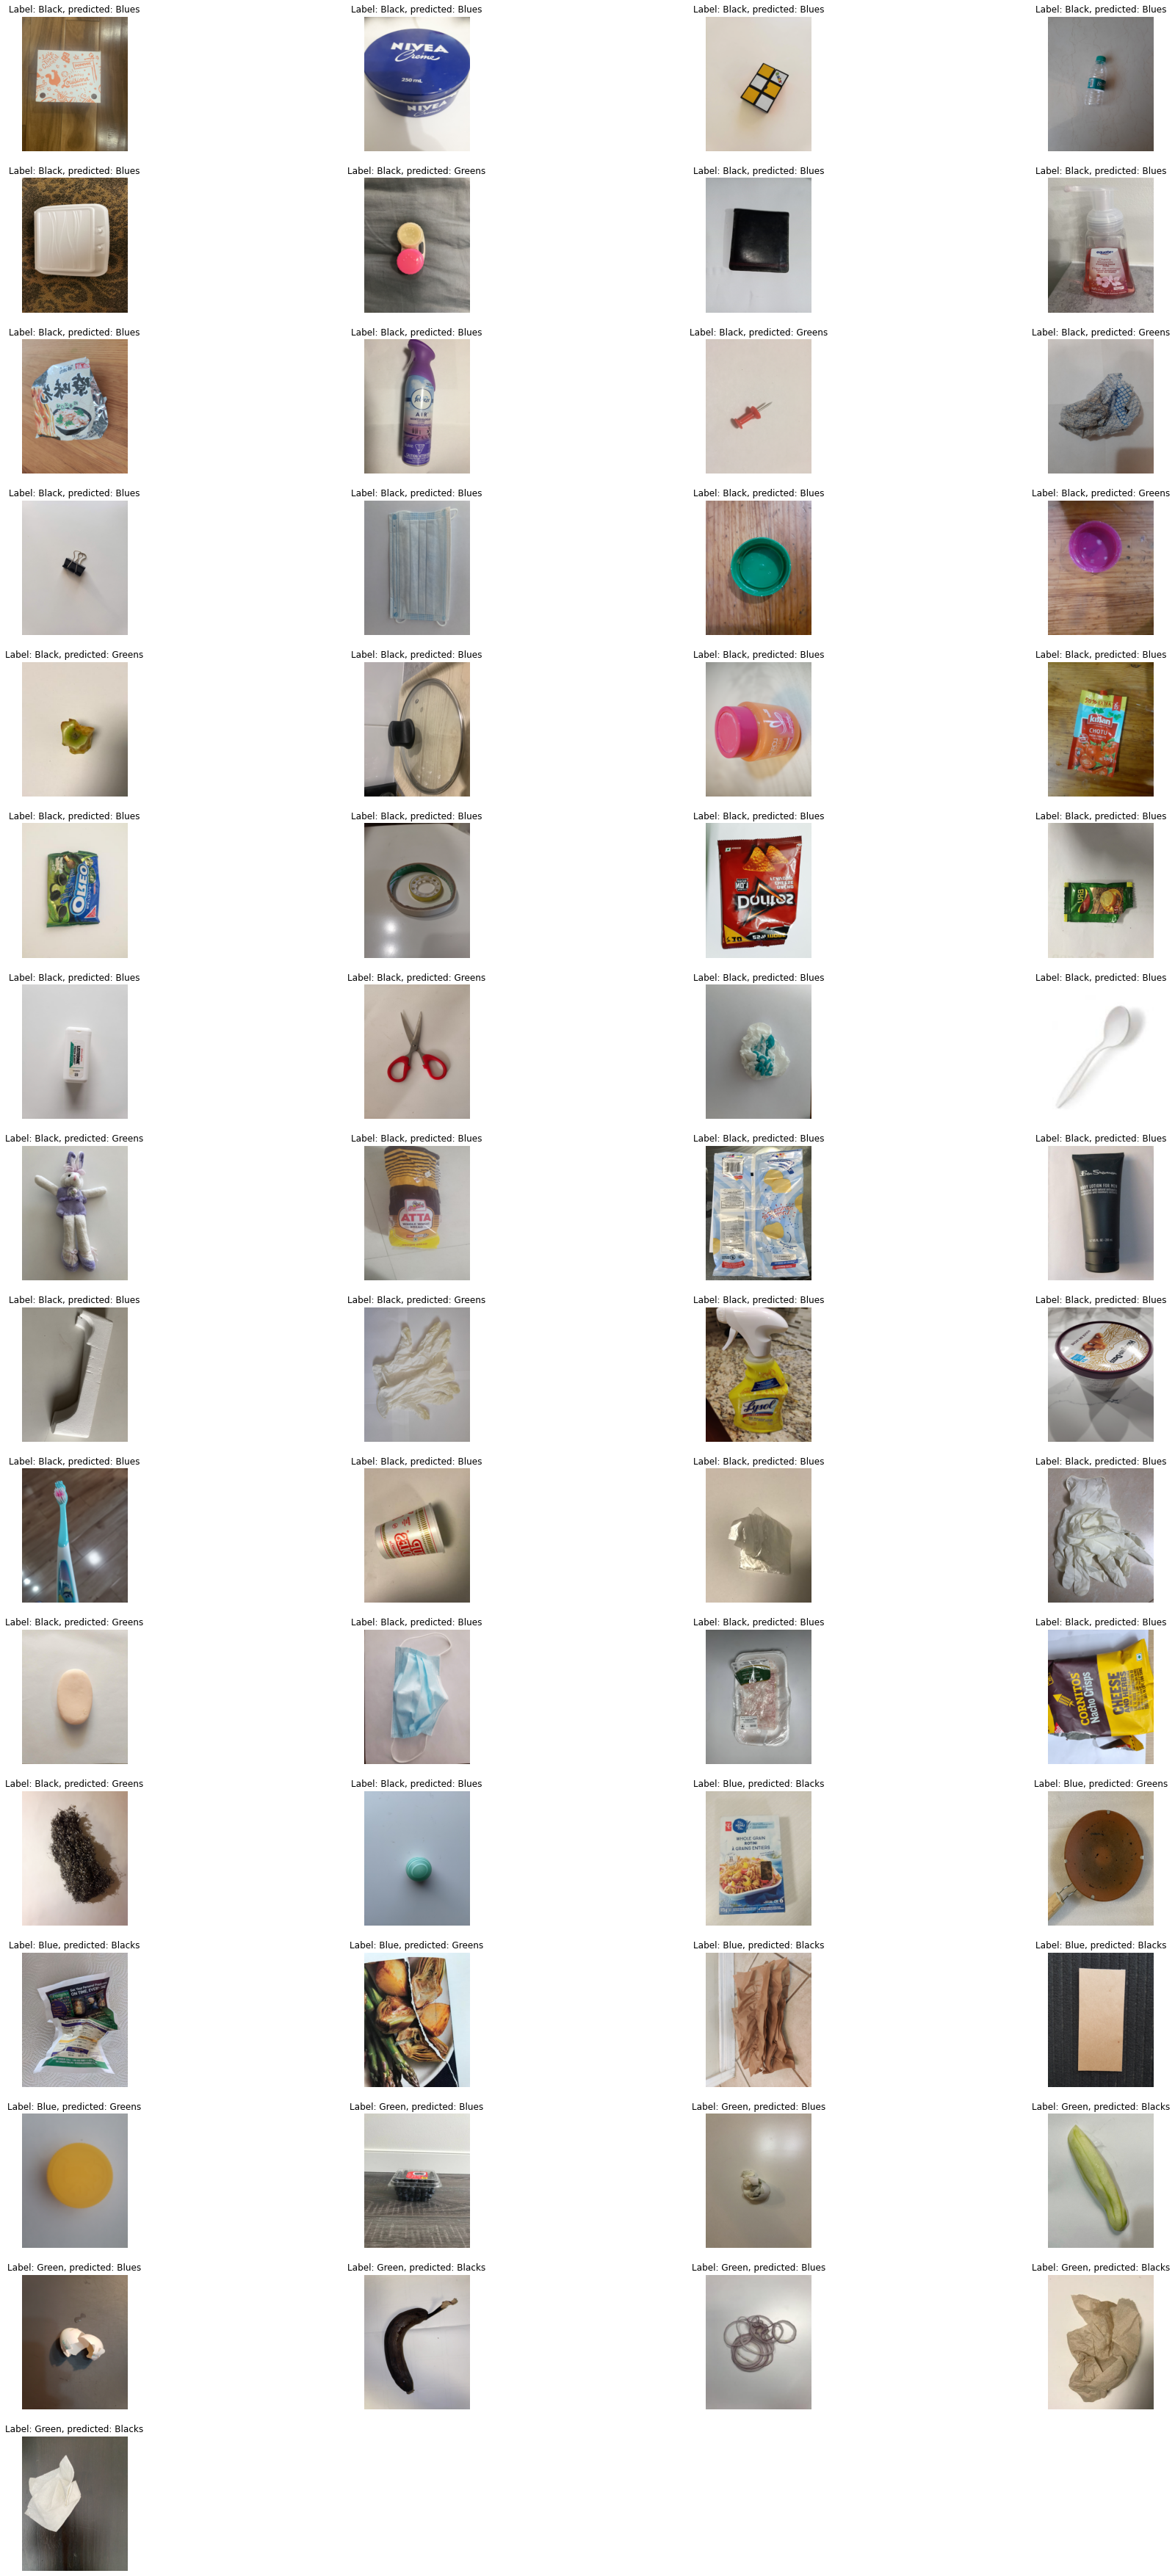

In [ ]:
img = []
true_label = []
pred_label = []
for ii in range(nb_samples//batch_size):
    Xbatch,Ybatch = test_generator.__getitem__(ii)
    Ybatch = Ybatch.argmax(axis = 1)
    Ypred = model.predict(Xbatch).argmax(axis = 1)
    wrong_indexes = np.where(Ypred != Ybatch)[0]
    for ii in wrong_indexes:
        img.append(Xbatch[ii])
        true_label.append(Ybatch[ii])
        pred_label.append(Ypred[ii])

columns = 4
rows = len(img)//columns + 1    
plt.figure(figsize = (32,64))
for ii in range(len(img)):
    plt.subplot(rows,columns,ii+1)
    plt.imshow(img[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Label: %s, predicted: %ss" %(class_names[true_label[ii]]\
                                            ,class_names[pred_label[ii]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Sonia** downloaded dataset (**score 1**)
- **Tabish** data pre-processing (**score 2**)
- **Nathan** Model Training (**score 3**)
- **Lai** Model Training (**score 3**)
- **Regina** task division, dataset creation, Model Creation, code revision (**score 3**)